In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


Opening file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Run for Freek's path

path = 'drive/My Drive/'

#!unzip drive/My\ Drive/data.zip > /dev/null

In [ ]:
#Get list of all files in test
import os
test_files = []
for filename in os.listdir('data/test/'):
    test_files.append(filename)
test_files = sorted(test_files)

#Get list of all files in train
train_files = []
for filename in os.listdir('data/train/'):
    train_files.append(filename)
train_files = sorted(train_files)

In [ ]:
#Listen to the sound
import IPython
filename = train_files[2]
IPython.display.Audio("/content/data/train/"+filename)

57390


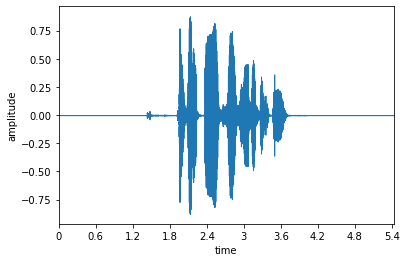

(13, 235)


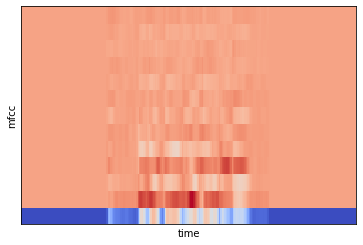

In [ ]:
import json
import librosa, librosa.display
import matplotlib.pyplot as plt
import os

sample_rate = 22050
size = 119809
n_fft = 2048
hop_length = 512



#get number of targets

#num_targets = 0 
#for key in train:
#  if int(train[key]) > num_targets:
 #   num_targets = int(train[key])
#print(num_targets)

#num_targets = 183


#waveplot
signal, sr = librosa.load("/content/data/train/"+filename, sr = sample_rate )
print(len(signal))
signal = librosa.util.pad_center(signal, size=size, mode='constant')
librosa.display.waveplot(signal, sr = sr)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

#mfcc
mfcc = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length=hop_length, n_mfcc = 13)
print(mfcc.shape)
shape = mfcc.shape
librosa.display.specshow(mfcc, sr = sr, hop_length=hop_length)
plt.xlabel("time")
plt.ylabel("mfcc")
plt.show()

Pre-processing

In [ ]:
#Normalize length: get n seconds centered on the middle of the signal
#Obtain the corresponding mfcc with n channels

import librosa
import re
import numpy as np

def to_mfcc(filename, in_path, sample_rate, seconds, mfcc_channels):
  
  signal, sr = librosa.load(in_path+filename, sr = sample_rate)
  length = len(signal)
  length2 = length / 2
  size = seconds * sample_rate
  halfsize = size/ 2
  n_fft = 2048
  hop_length = 512

  if length < size:
    signal = librosa.util.pad_center(signal, size=size, mode='constant')
  else:
    signal = signal[int(length2) - int(halfsize) : int(length2) + int(halfsize)]


  mfcc = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length=hop_length, n_mfcc = mfcc_channels).T

  print(filename)
  return mfcc

In [ ]:
import sklearn
import json
import numpy as np 


with open(path+'train.json', "r") as f:
    data_train = json.load(f)

In [ ]:
X_files = list(data_train.keys()) #👽
y = list(data_train.values())

In [ ]:
#Run through all 30k files in train folder
in_path = '/content/data/train/'

mfcc = to_mfcc(filename = "1000268201_693b08cb0e_4.wav", in_path = in_path, sample_rate = 22050, seconds = 4, mfcc_channels=18)

dim2 = mfcc.shape
print(dim2)
#dim = np.loadtxt(path+'processed_data/train/3181409177_edb09c2718_4.csv').shape
X = np.zeros((30000, dim2[0], dim2[1]))
X.shape

1000268201_693b08cb0e_4.wav
(173, 18)


(30000, 173, 18)

In [ ]:

for i, file in enumerate(X_files):
  mfcc = to_mfcc(filename = file, in_path = in_path, sample_rate = 22050, seconds = 4, mfcc_channels=13)
  X[i,:,:] = mfcc

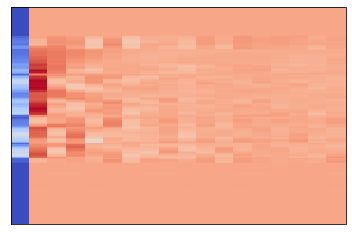

In [ ]:
librosa.display.specshow(X[29999], sr = sr, hop_length=hop_length)

In [ ]:
np.save(path+'processed_data/train/X_train_mfcc', X)

# **Model**

In [4]:
import numpy as np
inputs = np.load(path+'processed_data/train/X_train_mfcc.npy')

In [5]:
import sklearn
import json
import numpy as np


with open(path+'train.json', "r") as f:
    data_train = json.load(f)

inputs_files = list(data_train.keys()) #👽
targets = list(data_train.values())


In [6]:
n_classes = len(list(set(targets)))

In [7]:
from sklearn.model_selection import train_test_split

inputs_train, inputs_val, targets_train, targets_val = sklearn.model_selection.train_test_split(inputs, 
                                                                                                  targets, 
                                                                                                  test_size = 0.3)

In [8]:
input_train_dim = inputs_train.shape
input_val_dim = inputs_val.shape

In [9]:
print(input_train_dim)

print(input_val_dim)

(21000, 173, 18)
(9000, 173, 18)


In [10]:
# Our vectorized labels
import torch

inputs_train = np.asarray(inputs_train).astype('float32')
inputs_train = inputs_train[..., np.newaxis].reshape(input_train_dim[0], 1, input_train_dim[1], input_train_dim[2])
targets_train = np.asarray(targets_train).astype('float32') - 1 #bc index starts at 0

inputs_val = np.asarray(inputs_val).astype('float32')
inputs_val = inputs_val[..., np.newaxis].reshape(input_val_dim[0], 1, input_val_dim[1], input_val_dim[2])
targets_val = np.asarray(targets_val).astype('float32') - 1 #bc index starts at 0

print(inputs_train.shape)
print(targets_train.shape)
in_shape = inputs_train[0].shape
print(in_shape)
inputs_train = torch.tensor(inputs_train)
targets_train = torch.tensor(targets_train).type(torch.LongTensor)
inputs_val = torch.tensor(inputs_val)

targets_val = torch.tensor(targets_val).type(torch.LongTensor)

(21000, 1, 173, 18)
(21000,)
(1, 173, 18)


In [11]:
#Run to move data to GPU
inputs_train, targets_train, inputs_val, targets_val = inputs_train.to(device), targets_train.to(device), inputs_val.to(device), targets_val.to(device)

In [12]:
import torch
from torch import nn, optim

model_1 = nn.Sequential()

# Add convolutional and pooling layers
model_1.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=64, stride = (2,2), kernel_size=(5,5), padding = (1,1)))
model_1.add_module('Relu_1', nn.ReLU())
model_1.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, stride = (3,2), padding = (1,1)))
model_1.add_module('BachNorm_1', nn.BatchNorm2d(64)) 

model_1.add_module('Conv_2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),padding = (1,1)))
model_1.add_module('Relu_2', nn.ReLU())
model_1.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, stride = (2,2)))
model_1.add_module('BachNorm_2', nn.BatchNorm2d(128))


model_1.add_module('Conv_3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),padding = (1,1)))
model_1.add_module('Relu_3', nn.ReLU())
model_1.add_module('BachNorm_3', nn.BatchNorm2d(256))


model_1.add_module('Conv_4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2,2),padding = (1,1)))
model_1.add_module('Relu_4', nn.ReLU())
model_1.add_module('MaxPool_4', nn.MaxPool2d(kernel_size=2)) 
model_1.add_module('BachNorm_4', nn.BatchNorm2d(512))  

# Add a Flatten layer to the model
model_1.add_module('Flatten', nn.Flatten())

# Add a Linear layer with 64 units and relu activation
model_1.add_module('Linear_1', nn.Linear(in_features=512*7*1, out_features=800, bias=True))
model_1.add_module('Relu_L_1', nn.ReLU())
model_1.add_module('Dropout_1', nn.Dropout(p=0.3))

# Add the last Linear layer.
model_1.add_module('Linear_2', nn.Linear(in_features=800, out_features=183, bias=True))
model_1.add_module('Out_activation', nn.Softmax(-1))


In [13]:
model_1 = model_1.to(device)

from torchsummary import summary
in_shape = (1, 173, 18)
summary(model_1, input_size=(in_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 86, 8]           1,664
              ReLU-2            [-1, 64, 86, 8]               0
         MaxPool2d-3            [-1, 64, 29, 5]               0
       BatchNorm2d-4            [-1, 64, 29, 5]             128
            Conv2d-5           [-1, 128, 29, 5]          73,856
              ReLU-6           [-1, 128, 29, 5]               0
         MaxPool2d-7           [-1, 128, 14, 2]               0
       BatchNorm2d-8           [-1, 128, 14, 2]             256
            Conv2d-9           [-1, 256, 14, 2]         295,168
             ReLU-10           [-1, 256, 14, 2]               0
      BatchNorm2d-11           [-1, 256, 14, 2]             512
           Conv2d-12           [-1, 512, 15, 3]         524,800
             ReLU-13           [-1, 512, 15, 3]               0
        MaxPool2d-14            [-1, 51

In [ ]:
from torch import optim
from random import shuffle


def train_model(model, x_train_, y_train_, x_valid_, y_valid_, batch_size, num_epochs):
    print("Training...")
    # Crete optimizer (RMSprop with learning rate = 0.001)
    #optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
    optimizer = optim.RMSprop(model_1.parameters(), lr=0.0001, weight_decay=0.0001)
    #optimizer = optim.RMSprop(model_1.parameters(), lr=0.00005, weight_decay=0.00005) # made the lr and weight_decay lower over time
    #optimizer = optim.RMSprop(model_1.parameters(), lr=0.000005, weight_decay=0.0001)
    # Create the loss function
    categorical_cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean')

    acc_history = []
    val_acc_history = []
    loss_history = []
    val_loss_history = []
    
    batch_indices = list(range(len(x_train_)//batch_size))

    shuffle(batch_indices)

    for epoch in range(num_epochs):
        print('Currently training epoch {} of {}'.format(epoch, num_epochs))
        model.train()
        running_train_acc = 0 
        running_train_loss = 0
        for b_idx in batch_indices:
            optimizer.zero_grad()
            
            # Create batch
            batch_start = b_idx * batch_size
            batch_end = (b_idx + 1) * batch_size
            data_batch = x_train_[batch_start : batch_end]
            y_batch = y_train_[batch_start : batch_end]
            
            # Forward pass
            predictions = model(data_batch).squeeze()

            # Calculate loss
            loss = categorical_cross_entropy_loss(predictions, y_batch)

            running_train_loss += float(loss)

            # Backward pass and update
            loss.backward()
            optimizer.step()

            # Calculate perfrmance metric (accuracy)
            accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == y_batch).sum() / len(y_batch)
            running_train_acc += accuracy



        train_acc = running_train_acc / len(batch_indices)
        train_loss = running_train_loss / len(batch_indices)

        model.eval()
        predictions = model(x_valid_).squeeze()
        val_acc = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == y_valid_).sum() / len(y_valid_)
        val_loss = float(categorical_cross_entropy_loss(predictions, y_valid_))

        acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print('Accuracy is {} on train set and {} on validation set'.format(train_acc, val_acc))

    print('Training done.')
    predictions = model(x_valid_).squeeze()
    accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == y_valid_).sum() / len(y_valid_)

    print("Accuracy on test set: {}".format(accuracy))
    
    return acc_history, val_acc_history, loss_history, val_loss_history

In [ ]:
acc_history, val_acc_history, loss_history, val_loss_history = train_model(model_1, inputs_train, targets_train, inputs_val, targets_val, batch_size=10, num_epochs = 100)

Training...
Currently training epoch 0 of 100
Accuracy is 0.989192008972168 on train set and 0.9790000319480896 on validation set
Currently training epoch 1 of 100
Accuracy is 0.989192008972168 on train set and 0.9787777662277222 on validation set
Currently training epoch 2 of 100
Accuracy is 0.989192008972168 on train set and 0.9791111350059509 on validation set
Currently training epoch 3 of 100
Accuracy is 0.9892871975898743 on train set and 0.9784444570541382 on validation set
Currently training epoch 4 of 100
Accuracy is 0.9892871975898743 on train set and 0.9788889288902283 on validation set
Currently training epoch 5 of 100
Accuracy is 0.9892871975898743 on train set and 0.9786666631698608 on validation set
Currently training epoch 6 of 100
Accuracy is 0.9892871975898743 on train set and 0.9790000319480896 on validation set
Currently training epoch 7 of 100
Accuracy is 0.9892871975898743 on train set and 0.9784444570541382 on validation set
Currently training epoch 8 of 100
Accur

In [ ]:
torch.save(model_1.state_dict(), path+'98%_model')
targets_train.shape

torch.Size([21000])